In [93]:
import jax.numpy as jnp
import jax.scipy as jsp
from jax import random

from jaxgp.covar import CovMatrixFF, CovMatrixFD, CovMatrixDD
from jaxgp.kernels import RBF

import matplotlib.pyplot as plt

In [94]:
def covar(X_split, kernel, kernel_params, noise=2e-3):
    KF = CovMatrixFF(X_split[0], X_split[0], kernel, kernel_params)
    KD = CovMatrixFD(X_split[0], X_split[1], kernel, kernel_params)
    KDD = CovMatrixDD(X_split[1], X_split[1], kernel, kernel_params)

    K_NN = jnp.vstack((jnp.hstack((KF,KD)), 
                       jnp.hstack((KD.T,KDD))))
    
    diag = jnp.diag_indices(len(K_NN))
    K_NN = K_NN.at[diag].add(noise**2)

    return K_NN

In [95]:
# Interval bounds from which to choose the data points
bounds = jnp.array([-5.0, 5.0])

# How many function and derivative observations should be chosen
num_f_vals = 1
num_d_vals = 100

dim = 1

# initial seed for the pseudo random key generation
seed = 3

# create new keys and randomly sample the above interval for training features
key, subkey = random.split(random.PRNGKey(seed))
x_func = random.uniform(subkey, (num_f_vals, dim), minval=bounds[0], maxval=bounds[1])
key, subkey = random.split(key)
x_der = random.uniform(subkey, (num_d_vals, dim), minval=bounds[0], maxval=bounds[1])

# noise with which to sample the training labels
noise = 0.02

X_split = [x_func, x_der]

kernel = RBF()
kernel_params = jnp.array([1.0, 1.0])

In [96]:
K = covar(X_split, kernel, kernel_params, noise)
U = jsp.linalg.cholesky(K)

In [97]:
key, subkey = random.split(key)
x_new = random.uniform(subkey, (1, dim), minval=bounds[0], maxval=bounds[1])
X_new = [x_func, jnp.vstack((x_der, x_new))]

In [98]:
K_1 = covar(X_new, kernel, kernel_params, noise)
U_1 = jsp.linalg.cholesky(K_1)

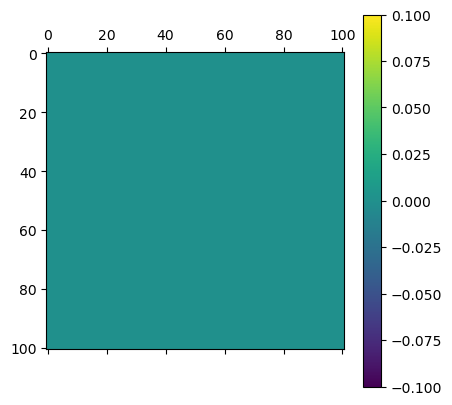

In [99]:
plt.matshow(U-U_1[:-1,:-1])
plt.colorbar()

In [100]:
a = K_1[-1,-1]
a_vec = K_1[:-1,-1]

In [101]:
c = jsp.linalg.solve_triangular(U.T, a_vec, lower=True)
d = jnp.sqrt(a - c@c)

In [102]:
print(U_1[-1,-1] - d)
print(jnp.mean(jnp.abs(U_1[:-1,-1]- c)))

-2.8889626e-06
4.5101608e-08


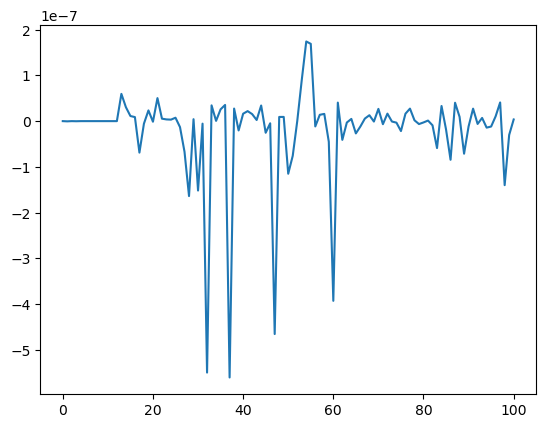

In [103]:
plt.plot(U_1[:-1,-1]- c)